# Probabilistic Matrix Factorization (PMF)

We have a matrix of $N_1$ users who have rated $N_2$ objects (movies). Let us call this matrix M, where $M_{ij}$ contains the rating for user i of object j. PMF is a generatve model in which we assume gaussian distribution for user and object locations and learn the gaussian parameters from the data (matrix). To obtain the parameters of the distribution we need to maximize the log-liklihood:

\begin{equation}
p(M_0, U, V)  = \left[ \prod_{(i,j) \in \Omega} p(M_{ij} | u_i, v_j) \right] x \left[ \prod_{j=1}^{N_2} p(v_j) \right] x \left[ \prod_{i  = 1}^{N_1} p(u_i)\right]
\end{equation}
 


## Required packages
Installing packages required for building and evaluating the model 

In [97]:
import numpy as np
import numpy.linalg as nplg
import pandas as pd
import matplotlib.pyplot as plt

% matplotlib inline

Reading the training ratings dataset

In [454]:
ratings_ml =  pd.read_csv('ratings_ml.csv')
ratings_ml.shape


(95000, 3)

In [242]:
ratings_ml.head()

,userId,movieId,rating
0,1,31,-1.035437
1,1,1029,-0.535437
2,1,1061,-0.535437
3,1,1129,-1.535437
4,1,1172,0.464563


Summary of training movie dataset

In [100]:
unique_users = ratings_ml['userId'].nunique()
unique_movies = ratings_ml['movieId'].nunique()
count_ratings = ratings_ml['rating'].count()

print('Number of unqiue users in the training dataset = {}'.format(unique_users))
print('Number of unqiue movies in the training dataset = {}'.format(unique_movies))
print('Count of ratings present in the training dataset = {}'.format(count_ratings)) 

Number of unqiue users in the training dataset = 624
Number of unqiue movies in the training dataset = 8793
Count of ratings present in the training dataset = 95000


## Preprocessing

In [455]:
#Substracting the mean rating from each rating
ratings_ml['rating'] = ratings_ml['rating'] - ratings_ml['rating'].mean()

Creating a unique Key ranging from 0 to 9055 corresponding to each movie Id for our analysis

In [456]:
#Loading the total ratings data 
tot_ratings =  pd.read_csv('ratings_ml_tot.csv')
tot_ratings.shape

(100004, 4)

In [403]:
uniq_movies = set(tot_ratings['movieId'])
uniq_movies = list(uniq_movies)
mylist = list(xrange(len(uniq_movies)))
key_df = pd.DataFrame({'movieId': uniq_movies,'movieKey': mylist}) 
ratings_fin = pd.merge(ratings_ml,key_df,how = 'left', left_on = ['movieId'], right_on = ['movieId'])
ratings_fin.head()

,userId,movieId,rating,movieKey
0,1,31,-1.035437,30
1,1,1029,-0.535437,870
2,1,1061,-0.535437,897
3,1,1129,-1.535437,947
4,1,1172,0.464563,975


In [104]:
#del ratings_fin['movieId']
ratings_fin.head()

,userId,movieId,rating,movieKey
0,1,31,-1.035437,30
1,1,1029,-0.535437,870
2,1,1061,-0.535437,897
3,1,1129,-1.535437,947
4,1,1172,0.464563,975


In [105]:
ratings_fin = ratings_fin[['userId','movieKey','rating']]
ratings_fin.head()

,userId,movieKey,rating
0,1,30,-1.035437
1,1,870,-0.535437
2,1,897,-0.535437
3,1,947,-1.535437
4,1,975,0.464563


In [106]:
ratings_fin.columns = [0,1,2]
ratings_fin.head()

,0,1,2
0,1,30,-1.035437
1,1,870,-0.535437
2,1,897,-0.535437
3,1,947,-1.535437
4,1,975,0.464563


Setting this data as the training dataset 

In [107]:
train = ratings_fin.values
train

array([[  1.00000000e+00,   3.00000000e+01,  -1.03543684e+00],
       [  1.00000000e+00,   8.70000000e+02,  -5.35436842e-01],
       [  1.00000000e+00,   8.97000000e+02,  -5.35436842e-01],
       ..., 
       [  6.24000000e+02,   7.60800000e+03,  -5.35436842e-01],
       [  6.24000000e+02,   3.16600000e+03,   4.64563158e-01],
       [  6.24000000e+02,   7.29600000e+03,  -5.35436842e-01]])

Doing the same pre processing to the test dataset

In [462]:
ratings_ml_test =  pd.read_csv('ratings_ml_test.csv', header= None)
ratings_test_fin = pd.merge(ratings_ml_test,key_df,how = 'left', left_on = [1], right_on = ['movieId'])
ratings_test_fin.head()

,0,1,2,movieId,movieKey
0,624,102125,3.0,102125,7296
1,624,102165,2.0,102165,7693
2,624,102278,2.0,102278,3295
3,624,102378,1.5,102378,3379
4,624,102407,3.5,102407,3398


In [463]:
del ratings_test_fin['movieId']
del ratings_test_fin[1]
ratings_test_fin.head()

,0,2,movieKey
0,624,3.0,7296
1,624,2.0,7693
2,624,2.0,3295
3,624,1.5,3379
4,624,3.5,3398


In [464]:
ratings_test_fin = ratings_test_fin[[0,'movieKey',2]]
ratings_test_fin.head()

,0,movieKey,2
0,624,7296,3.0
1,624,7693,2.0
2,624,3295,2.0
3,624,3379,1.5
4,624,3398,3.5


In [466]:
ratings_test_fin.columns = [0,1,2]
ratings_test_fin.head()

,0,1,2
0,624,7296,3.0
1,624,7693,2.0
2,624,3295,2.0
3,624,3379,1.5
4,624,3398,3.5


## Preprocessing for test dataset
Substracting the mean rating from each rating in the test dataset

In [112]:
ratings_test_fin[2] = ratings_test_fin[2] - ratings_test_fin[2].mean()

In [113]:
ratings_test_fin.head()

,0,1,2
0,624,7296,-0.698601
1,624,7693,-1.698601
2,624,3295,-1.698601
3,624,3379,-2.198601
4,624,3398,-0.198601


In [114]:
test = ratings_test_fin.values
test

array([[  6.24000000e+02,   7.29600000e+03,  -6.98601399e-01],
       [  6.24000000e+02,   7.69300000e+03,  -1.69860140e+00],
       [  6.24000000e+02,   3.29500000e+03,  -1.69860140e+00],
       ..., 
       [  6.71000000e+02,   4.85000000e+03,   3.01398601e-01],
       [  6.71000000e+02,   4.86300000e+03,  -1.19860140e+00],
       [  6.71000000e+02,   4.96000000e+03,  -1.98601399e-01]])

## Converting data into a user item rating matrix

In [115]:
train_matrix = np.zeros((671,9066))

for i in range(train.shape[0]):
    train_matrix[int(train[i][0])-1][int(train[i][1])-1] = train[i][2]

In [116]:
train_matrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

Converting the matrix into a Dataframe

In [151]:
train_matrix_df = pd.DataFrame(train_matrix)
train_matrix_df.head()

,0,1,2,3,4,5,6,7,8,9,...,9056,9057,9058,9059,9060,9061,9062,9063,9064,9065
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.464563,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.464563,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.464563,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [117]:
# Since ratings cannot be 0 we replace all nan's with 0s so as to not use them
ind_matrix = train_matrix.copy()
ind_matrix[ind_matrix!=0]=1

In [118]:
def RMSE(u,v,test):
    s=0
    for i in range(test.shape[0]):
        pred=u[int(test[i][0])-1].dot(v[int(test[i][1])-1])
        s+=(pred-test[i][2])**2

    return (s/test.shape[0])**(0.5)

Constructing the PMF Model

In [119]:

N1 = train_matrix.shape[0]
N2 = train_matrix.shape[1]

# Assume a Gaussian distribution for user and object location vectors
sigma2 = 0.25
d = 10
lam = 1

mean = np.zeros(d)
cov = lam*np.diag(np.ones(d))
objective_all=[]
RMSE_all = []

for runs in range(10):

    # Initialize u and v (Assumption: Gaussian distribution)
    u = np.random.multivariate_normal(mean,cov,N1)
    v = np.random.multivariate_normal(mean,cov,N2) 
    objective=[]

# Coordinate decent for optimizing the log-liklihood

    for itr in range(100):
        if itr % 10 ==0:
            print itr
            
        # Update u
        for i in range(N1):
            sum1 = np.zeros((10,10))
            sum2 = np.zeros(10)

            for j in np.where(ind_matrix[i]==1)[0]:
                sum1 = sum1 + np.outer(v[j],v[j])
                sum2 = sum2 + (train_matrix[i][j])*v[j]

            u[i] = ((nplg.inv(sigma2*cov + sum1)).dot(sum2.reshape(10,1))).flatten()

        # Update v
        for i in range(N2):
            sum1 = np.zeros((10,10))
            sum2 = np.zeros(10)

            for j in np.where(ind_matrix[:,i]==1)[0]:
                sum1 = sum1 + np.outer(u[j],u[j])
                sum2 = sum2 + train_matrix[j][i]*u[j]

            v[i] = ((nplg.inv(sigma2*cov + sum1)).dot(sum2.reshape(10,1))).flatten()

        obj = - np.sum((1.0/(2*sigma2))*np.square(train_matrix - (u.dot(np.transpose(v)))*ind_matrix)) \
              - np.sum((lam/2.0)*np.square(nplg.norm(u,2,1)))- np.sum((lam/2.0)*np.square(nplg.norm(v,2,1)))
            
        objective.append(obj)
    obj_best = -float('Inf')
    # Update best objective function value and corresponding u and v
    if obj_best <= objective[-1]:
        obj_best = objective[-1]
        v_best = v.copy()
        u_best = u.copy()
        
    objective_all.append(objective)
    RMSE_all.append(RMSE(u,v,test))

    

0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90


## Final Item feature matrix

In [120]:
v_best

array([[ 0.18168196,  0.37970492,  0.08288368, ...,  0.09697879,
        -0.03102561, -0.05892977],
       [ 0.86248056,  0.19019513,  0.00859674, ...,  0.70921804,
         0.32818513, -0.45794892],
       [ 0.49109631,  0.61473904, -0.30171351, ..., -0.58360569,
        -0.43990826, -0.83891317],
       ..., 
       [ 0.00583529, -0.00661926,  0.00344763, ..., -0.00145984,
        -0.00358124,  0.0051443 ],
       [ 0.30653327, -0.07145226,  0.1304083 , ..., -0.17021568,
        -0.31974436, -0.30914019],
       [-0.05617365,  0.37830171, -0.24638162, ..., -0.13048572,
         0.04650167, -0.04184024]])

# Hyper parameter tunning 

## Plotting convergence of Log-Liklihood with iterations

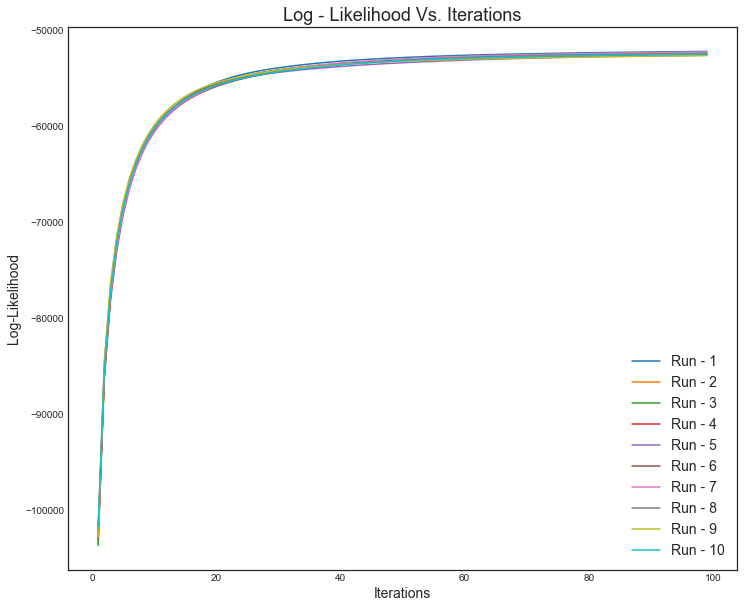

In [483]:

sns.set_style("white")
plt.figure(figsize=(12,10))
plt.title("Log - Likelihood Vs. Iterations", fontsize = 18)
plt.xlabel("Iterations",fontsize = 14)
plt.ylabel("Log-Likelihood",fontsize = 14)
run=1
for obj in objective_all:    
    plt.plot(range(1,100),obj[1:],label="Run - " + str(run))
    plt.legend(fontsize = 14)
    run=run+1
    
    
plt.savefig('log_likelihood_iter.png')

The log-liklihood starts converging at close to 25-30 iterations

# Model Evaluation

## 1. Model accuracy: RMSE measure

In [272]:
# # RMSE Table
# Sort Objective function by RMSE and store in dataframe

RMSE_all = np.array(RMSE_all)
RMSE_sorted = RMSE_all[np.argsort(RMSE_all)]
objective_all = np.array(objective_all)

RMSE_df = pd.DataFrame()
RMSE_df['Run'] = np.argsort(RMSE_all)+1
RMSE_df['Objective'] = objective_all[np.argsort(RMSE_all),-1].round()
RMSE_df['RMSE'] = RMSE_sorted.round(2)
RMSE_df

,Run,Objective,RMSE
0,3,-52603.0,0.96
1,6,-52514.0,0.97
2,4,-52480.0,0.97
3,1,-52253.0,0.97
4,7,-52307.0,0.97
5,5,-52666.0,0.97
6,10,-52520.0,0.97
7,2,-52398.0,0.97
8,8,-52468.0,0.97
9,9,-52680.0,0.97


## Run #3 gives the best RMSE of 0.96. 

In [131]:
v_best_df = pd.DataFrame(v_best)
v_best_df.to_csv("v_best_df.csv")

In [128]:
v_best_df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.181682,0.379705,0.082884,0.068724,0.518867,-0.058651,0.184970,0.096979,-0.031026,-0.058930
1,0.862481,0.190195,0.008597,0.015118,0.206916,-0.040701,0.187284,0.709218,0.328185,-0.457949
2,0.491096,0.614739,-0.301714,-0.239829,-0.587208,-0.451638,0.560999,-0.583606,-0.439908,-0.838913
3,0.081438,0.539114,0.417587,0.424071,0.160224,0.046398,0.407351,-0.692606,0.027667,0.179440
4,-0.306434,0.073493,0.350136,-0.081835,0.537911,0.149230,-0.229356,-0.241654,0.147249,0.065574


In [415]:
new_movie_fet = v_best_df.copy() 
new_movie_fet['movieKey'] = new_movie_fet.index
new_movie_fet.head()

,0,1,2,3,4,5,6,7,8,9,movieKey
0,0.181682,0.379705,0.082884,0.068724,0.518867,-0.058651,0.184970,0.096979,-0.031026,-0.058930,0
1,0.862481,0.190195,0.008597,0.015118,0.206916,-0.040701,0.187284,0.709218,0.328185,-0.457949,1
2,0.491096,0.614739,-0.301714,-0.239829,-0.587208,-0.451638,0.560999,-0.583606,-0.439908,-0.838913,2
3,0.081438,0.539114,0.417587,0.424071,0.160224,0.046398,0.407351,-0.692606,0.027667,0.179440,3
4,-0.306434,0.073493,0.350136,-0.081835,0.537911,0.149230,-0.229356,-0.241654,0.147249,0.065574,4


In [429]:
vbest_w_id = pd.merge(new_movie_fet,key_df, how = 'left', left_on = ['movieKey'], right_on = ['movieKey'])
vbest_w_id.movieId.max()

163949

Looking at the user feature matrix 

In [132]:
u_best_df = pd.DataFrame(u_best)
u_best_df.to_csv("u_best_df.csv")

In [130]:
u_best_df.head()

,0,1,2,3,4,5,6,7,8,9
0,-1.531814,-1.203776,1.210292,-1.917027,-0.670182,-1.221317,-0.255783,1.102115,0.644616,0.996236
1,-0.146235,-0.095634,-0.266888,-0.847841,0.814271,0.544341,-2.492251,-0.030672,-1.065321,-1.526589
2,0.055559,-0.809305,-0.363773,0.146568,-0.354603,0.635479,-1.023717,-0.696411,0.575030,0.501358
3,0.330837,0.539049,-2.597085,0.574089,1.369748,0.193365,-0.729239,0.150742,0.026561,0.074169
4,0.940548,0.682828,-0.027098,0.011350,0.061023,0.123506,-0.123541,-0.302248,-0.160815,0.649464


Creating the final ratings matrix by multiplying the item feature and user feature matrix

In [134]:
final_rating = np.dot(u_best_df,(v_best_df.T))
final_rating_df = pd.DataFrame(final_rating)

In [139]:
final_rating_df.shape

(671, 9066)

Replacing the moviekey by the original movieId

In [245]:
key_df.head()

,movieId,movieKey
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4


In [ ]:
movieId = key_df['movieId']

Final ratings matrix

In [152]:
final_rating_df.columns = movieId
final_rating_df.head()
#final_rating_df.to_csv("final_rating_df.csv")

movieId,1,2,3,4,5,6,7,8,9,10,...,98230,65465,98243,131013,32728,32735,32743,65514,70994,98296
0,-1.062056,-1.168588,-2.358572,-1.916247,0.371402,-2.942994,-1.866330,-1.074722,-0.236120,-0.693676,...,0.251627,-1.201962,-0.572918,-0.799834,-0.188673,-0.030253,3.389844,0.014392,-2.086257,-0.802689
1,-0.093650,-0.152128,-0.201667,-1.676122,0.855007,2.361760,-1.030694,0.390130,-0.188114,-0.303916,...,-0.190755,-0.794950,-0.757871,-0.234022,0.156548,0.004591,-2.297474,-0.011941,0.084723,1.292098
2,-0.842824,-0.932670,-1.315835,-0.377665,0.208855,0.277132,-0.777370,-1.030704,0.012940,-0.590945,...,0.058503,-0.821299,-0.745069,-0.128872,0.038888,-0.005879,-0.864778,-0.002966,-0.302845,-0.080844
3,0.662896,0.594856,-0.322899,-0.682482,-0.112816,1.151723,0.582378,-0.343927,0.174774,0.435953,...,-0.415153,0.411975,0.108130,0.364971,0.154059,-0.007452,-0.475688,-0.011752,0.032644,1.631207
4,0.367660,0.360918,0.428489,0.724830,-0.076911,0.574887,0.532443,-0.555699,0.257946,0.577601,...,-0.016393,0.272838,0.194544,0.231929,-0.055707,0.012340,-0.679750,0.004249,0.143165,0.283154


# 2. Trend: Movie popularity vs predicted rating 
Here we look at how the popularity of a movie and its mean predicted rating are related after using our model. Popularity and mean rating are defined as below:


Popularity:  Number of times the movie was rated in the given dataset 

Mean Rating: Mean rating of the movie after prediction 

We follow the below mentioned approach:
* Create quantiles of the mean predicted rating
* Find total popularity of the movies in the given quantiles 

In [247]:
mv_rating = final_rating_df.mean(axis = 0)
mv_rating.head()

movieId
1   -0.174548
2   -0.649965
3   -0.789930
4   -0.403460
5    0.271831
dtype: float64

Creating quantiles for the predicted rating

In [467]:
quant= mv_rating.quantile([.33, .66])
quant

0.33   -0.111009
0.66    0.032071
dtype: float64

Separating movieIds on the basis of the quntile rating they fall in 

In [476]:
quant1 = mv_rating.loc[            mv_rating <= -0.111]
quant2 = mv_rating.loc[(mv_rating > -0.111)  & (mv_rating <= 0.032)]
quant3 = mv_rating.loc[(mv_rating >  0.032) ]

quant1_mv_id = pd.DataFrame(list(quant1.index))
quant2_mv_id = pd.DataFrame(list(quant2.index))
quant3_mv_id = pd.DataFrame(list(quant3.index))

quant1_mv_id["quantile"] = "Q1: Low Rating"
quant2_mv_id["quantile"] = "Q2: Medium Rating"
quant3_mv_id["quantile"] = "Q3: High Rating"

quant_tot_id = pd.concat([quant1_mv_id,quant2_mv_id,quant3_mv_id], axis= 0)
quant_tot_id.columns = ['movieId', 'rating_quantile']
quant_tot_id.head()


,movieId,rating_quantile
0,1,Q1: Low Rating
1,2,Q1: Low Rating
2,3,Q1: Low Rating
3,4,Q1: Low Rating
4,6,Q1: Low Rating


Total movie dataset:  How popular a movie is : No of times a movie has been rated : MovieId, freq

In [477]:
mov_pop = pd.DataFrame(tot_ratings['movieId'].value_counts())
mov_pop['movieId1'] = mov_pop.index
mov_pop.columns = ['freq', 'MovieID']
mov_pop.head()

,freq,MovieID
356,341,356
296,324,296
318,311,318
593,304,593
260,291,260


In [478]:
ratings_quant_fin = pd.merge(mov_pop,quant_tot_id, how = 'left', left_on = ['MovieID'], right_on = ['movieId'])
del ratings_quant_fin['MovieID']
ratings_quant_fin.head()
X =ratings_quant_fin.groupby(['rating_quantile']).freq.sum()
pop_df = pd.DataFrame(X)
pop_df['quantile']= pop_df.index
pop_df.head()

,freq,quantile
rating_quantile,,
Q1: Low Rating,38385,Q1: Low Rating
Q2: Medium Rating,25271,Q2: Medium Rating
Q3: High Rating,36348,Q3: High Rating


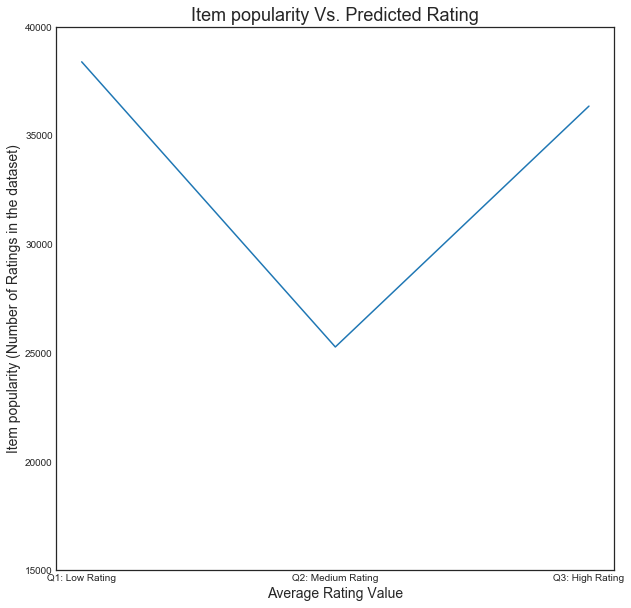

In [485]:
# Plotting final movie ratings vs Popularity 
sns.set_style("white")
plt.figure(figsize=(10,10))
plt.ylim(ymin =15000,ymax= 40000) 
plt.title("Item popularity Vs. Predicted Rating", fontsize = 18)
plt.xlabel("Average Rating Value",fontsize = 14)
plt.ylabel("Item popularity (Number of Ratings in the dataset)",fontsize = 14)
plt.plot(pop_df['quantile'],pop_df['freq'])

plt.savefig('pop_rating.png')

As we can see above, the model does not necessarily give a higher rating to a more popular movie. Thus the model might be able to recommend movies that are not very popular and can give serendipitous recommendations.

## How personalized are our recommendations ?

We pick a user at random, find the most similar user and a very dissimilar user and see how the different are our recommendations for them. 

We follow the below given approach for the same:
* Pick a user at random, calculate the distances between all users and this user. Hence find the most similar and dissimilar user to the chosen user 
* Find the best recommended movie to all the three users 
* Find the distances between the recommended movies 

Our premise is that, the distance between recommended movies of simmilar users will be less compared to the distance between dissimilar users

In [349]:
# Picking user 1 at random (getting feature array of user 1)
v_user = u_best[0]
v_user

array([-1.53181406, -1.20377611,  1.21029196, -1.91702663, -0.67018246,
       -1.22131688, -0.2557834 ,  1.10211501,  0.64461623,  0.99623635])

In [355]:
# Finding indices of the most similar and most dissimilar user 
dist_user = []
for vec in u_best: 
    dist_user.append(nplg.norm(v_user-vec,2)**2)
    
dist_user = np.array(dist_user).round(2)
dist_user_sort = dist_user[np.argsort(dist_user)]

In [342]:
closest_user  = np.where(dist_user==4.6)
farthest_user = np.where(dist_user==74.65)
print closest_user, farthest_user

(array([352]),) (array([256]),)


In [400]:
ini = np.array(final_rating_df.loc[final_rating_df.index == 0]).round(2)
top_rec_user = np.sort(ini)[:3]

#Movie Id of the top recommended movie of the chosen user 
mv1 = np.where(ini == -5.48 ) #MovieId: 149

rec_mv1 = np.array(final_rating_df.loc[final_rating_df.index == 352]).round(2)
top_rec_sim = np.sort(rec_mv1)[:3]

#Movie Id of the top recommended movie of the most similar user 
sim_mv1 = np.where(rec_mv1 == -4.93 ) #MovieId: 7354

rec_mv2 = np.array(final_rating_df.loc[final_rating_df.index == 256]).round(2)
top_rec_dis_sim = np.sort(rec_mv2)[:3]

#Movie Id of the top recommended movie of the most dissimilar user 
dissim_mv1 = np.where(rec_mv2 == -13.08 ) #MovieId: 1527


In [482]:
orig_movie = vbest_w_id.loc[(vbest_w_id.movieId == 149) ]
del orig_movie['movieKey']
del orig_movie['movieId']

orig_movie = np.array(orig_movie)

simm_movie = vbest_w_id.loc[(vbest_w_id.movieId == 7354) ]
del simm_movie['movieKey']
del simm_movie['movieId']
simm_movie = np.array(simm_movie)


diss_simm_movie = vbest_w_id.loc[(vbest_w_id.movieId ==1527) ]
del diss_simm_movie['movieKey']
del diss_simm_movie['movieId']
diss_simm_movie = np.array(diss_simm_movie)



dist_sim_movie    = (nplg.norm(orig_movie-simm_movie,2)**2).round(2)
dist_dissim_movie = (nplg.norm(orig_movie-diss_simm_movie,2)**2).round(2)

print('Distance between movie features of the top movie recommendation of two similar users = {}').format(dist_sim_movie)
print('Distance between movie features of the top movie recommendation of two dissimilar users = {}').format(dist_dissim_movie)

Distance between movie features of the top movie recommendation of two similar users = 0.47
Distance between movie features of the top movie recommendation of two dissimilar users = 0.6


As discussed in our premise we can see that the distances between movie recommendations of two dissimilar users is greater than that between two similar users. 

Another point to note here is that, the distance of 0.47 between top recommendation of two closest users suggests that the recommendations are personalized. 

## 3. Let us now look at the movies which are closest to “Star Wars” and “My Fair Lady” based on the ratings matrix

In [123]:
movies_ml =  pd.read_csv('movies_ml.csv')
movies_ml.head()
movies_list = list(movies_ml['title'])

In [124]:
content = [x.split('(')[0] for x in movies_list] 
content = [x.strip() for x in content] 
content[0]

'Toy Story'

In [125]:
# Store the index of the movies “Star Wars” “My Fair Lady” in 2 variables
import re
movie1 = "Star Wars"
movie2 = "My Fair Lady"

for mv in content:
    if movie1 in mv:
        ind1=content.index(mv)
        
    if movie2 in mv:
        ind2=content.index(mv)


# Get Eucledian distance of these 3 movies with all other movies 
dist_SW = []
dist_MFL = []

v_SW = v_best[ind1]
v_MFL = v_best[ind2]

for vec in v_best:
    dist_SW.append(nplg.norm(v_SW-vec,2)**2)
    dist_MFL.append(nplg.norm(v_MFL-vec,2)**2)

dist_SW = np.array(dist_SW)
dist_MFL = np.array(dist_MFL)

content = np.array(content)
top_movies = pd.DataFrame()

# Sort the movies by distances and store in a data frame
content[np.argsort(dist_SW)[1:11]]
dist_SW[np.argsort(dist_SW)[:11]]

top_movies['Star Wars'] = content[np.argsort(dist_SW)[1:11]]
top_movies['Distance (Star Wars)'] = dist_SW[np.argsort(dist_SW)[1:11]].round(2)

top_movies['My Fair Lady'] = content[np.argsort(dist_MFL)[1:11]]
top_movies['Distance (My Fair Lady)'] = dist_MFL[np.argsort(dist_MFL)[1:11]].round(2)

top_movies.index = top_movies.index + 1

# Display the dataframe
top_movies

,Star Wars,Distance (Star Wars),My Fair Lady,Distance (My Fair Lady)
1,Star Wars: Episode VII - The Force Awakens,0.0,My Fair Lady,0.00
2,Walker,0.0,"Punisher, The",0.00
3,Citizen X,0.0,RoboCop 2,0.00
4,Kingdom of Heaven,0.0,"Stunt Man, The",0.00
5,Nazarin,0.0,Our Lady of the Assassins,0.00
6,Zenon: Z3,0.0,All the Pretty Horses,0.01
7,Ashes of Time,0.0,35 Up,0.01
8,Lars and the Real Girl,0.0,"Secret World of Arrietty, The",0.02
9,Series 7: The Contenders,0.0,Wimbledon,0.02
10,My Tutor,0.0,Sky Captain and the World of Tomorrow,0.02
